# Определение перспективного тарифа для телеком компании

# Оглавление

1. [Описание проекта](#project)
2. [Просмотр данных](#start)
3. [Предобработка данных](#preprocessing)
   - [Таблица **calls**](#calls)
   - [Таблица **messages**](#messages)
   - [Таблица **internet**](#internet)
   - [Таблица **users**](#users)
   - [Таблица **tariffs**](#tariffs)
   - [Сводная таблица по всем данным](#united)
   - [Выручка с каждого клиента по месяцам](#revenue)
4. [Анализ данных](#anlysis)
   - [Общий анализ данных](#general)
   - [Гистограмма длительности звонков](#histcalls)
   - [Гистограмма используемого трафика интернета](#histinternet)
   - [Гистограмма количества отправленных сообщений](#histmess)
   - [Гистограмма выручки сверх тарифа](#histrevenue)
   - [Гистограмма общей выручки](#histrevenuetotal)
5. [Проверка гипотез](#suppose)
   -  [Гипотеза: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"](#version1)
   -  [Гипотеза: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"](#version2)
6. [Общий вывод по проекту](#inference)

## **Описание проекта** <a id="project"></a>

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Компания предоставила данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей
  
**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Описание данных**

- Таблица **users** (информация о пользователях):

   - user_id — уникальный идентификатор пользователя
   - first_name — имя пользователя
   - last_name — фамилия пользователя
   - age — возраст пользователя (годы)
   - reg_date — дата подключения тарифа (день, месяц, год)
   - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
   - city — город проживания пользователя
   - tariff — название тарифного плана

- Таблица **calls** (информация о звонках):

   - id — уникальный номер звонка
   - call_date — дата звонка
   - duration — длительность звонка в минутах
   - user_id — идентификатор пользователя, сделавшего звонок

- Таблица **messages** (информация о сообщениях):

   - id — уникальный номер сообщения
   - message_date — дата сообщения
   - user_id — идентификатор пользователя, отправившего сообщение

- Таблица **internet** (информация об интернет-сессиях):

   - id — уникальный номер сессии
   - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
   - session_date — дата интернет-сессии
   - user_id — идентификатор пользователя

- Таблица **tariffs** (информация о тарифах):

   - tariff_name — название тарифа
   - rub_monthly_fee — ежемесячная абонентская плата в рублях
   - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
   - messages_included — количество сообщений в месяц, включённых в абонентскую плату
   - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
   - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
   - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
   - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Просмотр данных <a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_columns', 100)
try: 
    users = pd.read_csv('/Users/iyaneklyudova/Downloads/users.csv')
    calls=pd.read_csv('/Users/iyaneklyudova/Downloads/calls.csv')
    messages=pd.read_csv('/Users/iyaneklyudova/Downloads/messages.csv')
    internet=pd.read_csv('/Users/iyaneklyudova/Downloads/internet.csv')
    tariffs=pd.read_csv('/Users/iyaneklyudova/Downloads/tariffs.csv')

except: 
    users=pd.read_csv('/datasets/users.csv')
    calls=pd.read_csv('/datasets/calls.csv')
    messages=pd.read_csv('/datasets/messages.csv')
    internet=pd.read_csv('/datasets/internet.csv')
    tariffs=pd.read_csv('/datasets/tariffs.csv')


Таблица **users**

In [2]:
users.info()
print()
print('Количество дубликатов:', users.duplicated().sum())
print('Количество уникальных пользоваетелей:', len(users['user_id'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Количество дубликатов: 0
Количество уникальных пользоваетелей: 500


In [3]:
display(users.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Пропуски есть только в колонке **churn_date**. Но пустые значения в этой колонке значат что тариф еще действует. Оставим как есть, для анализа эта колонка не понадобится.
Формат колонок с датой необходимо перевести в datetime. Дубликатов нет

Таблица **calls**

In [4]:
calls.info()
print()
print('Количество дубликатов:',calls.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Количество дубликатов: 0


In [5]:
display(calls.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Пропусков и дубликатов нет. Но длительность звонков представлена дробными числами, а оператор округляет все данные в большую сторону. Также есть звонки длительностью 0 минут. Это могут быть неотвеченные вызовы или случаи когда связь сразу обрывалась. Тк нулевые звонки не приносят приносят прибыли оператору, то удалим эти строки. Формат колонки с датой необходимо перевести в datetime

Таблица **messages**

In [6]:
messages.info()
print()
print('Количество дубликатов:', messages.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Количество дубликатов: 0


In [7]:
display(messages.head(7))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000


Пропусков и дубликатов нет. Формат колонки с датой необходимо перевести в datetime

Таблица **internet**

In [8]:
internet.info()
print()
print('Количество дубликатов:',internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Количество дубликатов: 0


In [9]:
display(internet.head())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Проверим есть ли нулевые значения

In [10]:
print(len(internet.query('mb_used == 0')))

19598


Пропусков и дубликатов нет. Но 19 тысяч строк с нулевым трафиком. Это может быть в случаях когда связь сразу обрывается. Нулевой трафик, как и нулевые звонки, не приносит  прибыли, поэтому удалим эти строки. Также данные по трафику представлены дробными числами, а опретор округляет данные в большую сторону. Формат колонки с датой необходимо перевести в datetime

Таблица **tariffs**

In [11]:
tariffs.info()
print(tariffs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
0


In [12]:
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всего 2 строки  с параметрами тарифов

Вывод. Пропуски есть всего в одном столбце, который не понадобится для анализа. Дубликатов нет. Есть нулевые значения, которые не влияют на прибыль. Поэтому их удалим. Данные о длительности звонков и трафике интернета округлим в большую сторону согласно правилам компании. А также поправим формат даты и добавим колонку с месяцем, тк будем объединять данные по месяцам.

## Предобработка данных <a id="preprocessing"></a>

### Таблица **calls** <a id="calls"></a>

Переведем формат даты и добавим колонку месяца.

In [13]:
calls['call_date']= pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Округлим данные о длительности звонков в большую сторону

In [14]:
calls['duration']=calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int')
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Удалим строки с нулевыми значениями

In [15]:
calls['duration']=calls['duration'].replace(0,np.NaN)
calls= calls.dropna()
print(len(calls.query('duration==0'))) #проверка на отсутствие нулевых значений

0


### Таблица **messages** <a id="messages"></a>

Переведем формат даты и добавим колонку месяца.

In [16]:
messages['message_date']= pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


### Таблица **internet** <a id="internet"></a>

Переведем формат даты и добавим колонку месяца.

In [17]:
internet['session_date']= pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


Округлим данные о трафике в большую сторону

In [18]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113,2018-11-25,1000,11
1,1,1000_1,1053,2018-09-07,1000,9
2,2,1000_2,1198,2018-06-25,1000,6
3,3,1000_3,551,2018-08-22,1000,8
4,4,1000_4,303,2018-09-24,1000,9


Удалим строки с нулевыми значениями

In [19]:
internet['mb_used']=internet['mb_used'].replace(0,np.NaN)
internet= internet.dropna()
print(len(internet.query('mb_used==0'))) #проверка на отсутствие нулевых значений

0


### Таблица **users** <a id="users"></a>

Переведем формат даты

In [20]:
users['reg_date']= pd.to_datetime(users['reg_date'], format ='%Y-%m-%d')
users['churn_date']= pd.to_datetime(users['churn_date'], format ='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Таблица **tariffs** <a id="tariffs"></a>

Проверим заголовки в таблице

In [21]:
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Колонка с названием тарифа называется **tariff_name**, а в таблице users эта колонка называется **tariff** Для того чтобы их можно было объединить, приведем их к одному названию **tariff**

In [22]:
tariffs.rename(columns=lambda x: x.replace('tariff_name', 'tariff'), inplace = True)
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Сводная таблица по всем данным <a id="united"></a>

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;

In [23]:
messages_count = messages.groupby(['user_id', 'month'])['id'].count()   #количество отправленных сообщений по месяцам
internet_count = internet.groupby(['user_id', 'month']).sum()['mb_used']  #объем израсходованного интернет-трафика по месяцам
calls_count = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])   #количество сделанных звонков и израсходованных минут разговора по месяцам;
data = pd.concat([calls_count,internet_count, messages_count], axis=1)  #Объединяем в одну таблицу
data=data.reset_index()
data.head(10)

,user_id,month,count,sum,mb_used,id
0,1000,5,17.0,159.0,2256.0,22.0
1,1000,6,28.0,172.0,23257.0,60.0
2,1000,7,41.0,340.0,14016.0,75.0
3,1000,8,42.0,408.0,14070.0,81.0
4,1000,9,46.0,466.0,14581.0,57.0
5,1000,10,44.0,350.0,14717.0,73.0
6,1000,11,37.0,338.0,14768.0,58.0
7,1000,12,38.0,333.0,9827.0,70.0
8,1001,11,45.0,430.0,18452.0,NaN
9,1001,12,47.0,414.0,14053.0,NaN


Переименуем столбцы для более понятного вида. 

In [24]:
data.columns=['user_id', 'Месяц','Кол-во звонков, шт', 'Общее время звонков, мин', 'Интернет, мб', 'Кол-во сообщений, шт']
data.head(10)

,user_id,Месяц,"Кол-во звонков, шт","Общее время звонков, мин","Интернет, мб","Кол-во сообщений, шт"
0,1000,5,17.0,159.0,2256.0,22.0
1,1000,6,28.0,172.0,23257.0,60.0
2,1000,7,41.0,340.0,14016.0,75.0
3,1000,8,42.0,408.0,14070.0,81.0
4,1000,9,46.0,466.0,14581.0,57.0
5,1000,10,44.0,350.0,14717.0,73.0
6,1000,11,37.0,338.0,14768.0,58.0
7,1000,12,38.0,333.0,9827.0,70.0
8,1001,11,45.0,430.0,18452.0,NaN
9,1001,12,47.0,414.0,14053.0,NaN


Добавим в таблицу данные абонентов

In [25]:
data= pd.merge(data, users, on = 'user_id', how= 'left')
display(data.head())

,user_id,Месяц,"Кол-во звонков, шт","Общее время звонков, мин","Интернет, мб","Кол-во сообщений, шт",age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,17.0,159.0,2256.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Чтобы таблица не была громоздкой удалим колонки, которые не потребуются для анализа.

In [26]:
data.drop(['churn_date','first_name','last_name', 'reg_date'], axis = 1, inplace=True)
display(data.head())

,user_id,Месяц,"Кол-во звонков, шт","Общее время звонков, мин","Интернет, мб","Кол-во сообщений, шт",age,city,tariff
0,1000,5,17.0,159.0,2256.0,22.0,52,Краснодар,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,Краснодар,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,Краснодар,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,Краснодар,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,Краснодар,ultra


Теперь добавим данные по тарифу

In [27]:
data= data.merge(tariffs, on = 'tariff', how= 'left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id                     3214 non-null int64
Месяц                       3214 non-null int64
Кол-во звонков, шт          3168 non-null float64
Общее время звонков, мин    3168 non-null float64
Интернет, мб                3201 non-null float64
Кол-во сообщений, шт        2717 non-null float64
age                         3214 non-null int64
city                        3214 non-null object
tariff                      3214 non-null object
messages_included           3214 non-null int64
mb_per_month_included       3214 non-null int64
minutes_included            3214 non-null int64
rub_monthly_fee             3214 non-null int64
rub_per_gb                  3214 non-null int64
rub_per_message             3214 non-null int64
rub_per_minute              3214 non-null int64
dtypes: float64(4), int64(10), object(2)
memory usage: 426.9+ KB


У нас появились проуски, тк некоторые аббоненты могли в течении месяца не звонить, не отправлять сообщений, не пользоваться интернетом. Заполним эти пропуски нулем. И тип данных снова преобразуем в целые числа.

In [28]:
data=data.fillna(0)
data[['Кол-во звонков, шт','Общее время звонков, мин','Интернет, мб', 'Кол-во сообщений, шт']]=data[['Кол-во звонков, шт','Общее время звонков, мин','Интернет, мб', 'Кол-во сообщений, шт']].astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id                     3214 non-null int64
Месяц                       3214 non-null int64
Кол-во звонков, шт          3214 non-null Int64
Общее время звонков, мин    3214 non-null Int64
Интернет, мб                3214 non-null Int64
Кол-во сообщений, шт        3214 non-null Int64
age                         3214 non-null int64
city                        3214 non-null object
tariff                      3214 non-null object
messages_included           3214 non-null int64
mb_per_month_included       3214 non-null int64
minutes_included            3214 non-null int64
rub_monthly_fee             3214 non-null int64
rub_per_gb                  3214 non-null int64
rub_per_message             3214 non-null int64
rub_per_minute              3214 non-null int64
dtypes: Int64(4), int64(10), object(2)
memory usage: 439.4+ KB


In [29]:
data

,user_id,Месяц,"Кол-во звонков, шт","Общее время звонков, мин","Интернет, мб","Кол-во сообщений, шт",age,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17,159,2256,22,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28,172,23257,60,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41,340,14016,75,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42,408,14070,81,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46,466,14581,57,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30,247,20604,42,68,Владикавказ,smart,50,15360,500,550,200,3,3
3210,1499,9,8,70,1848,11,35,Пермь,smart,50,15360,500,550,200,3,3
3211,1499,10,44,449,17809,48,35,Пермь,smart,50,15360,500,550,200,3,3
3212,1499,11,62,612,17984,59,35,Пермь,smart,50,15360,500,550,200,3,3


### Выручка с каждого клиента по месяцам <a id="revenue"></a>

Посчитаем помесячную выручку с каждого пользователя 

In [30]:
def revenue_per_month(row):
    revenue = 0 
    #if row['Кол-во звонков, шт'] > row['minutes_included']:
    if row['Общее время звонков, мин'] > row['minutes_included']:
        extra_minutes_cost = (row['Общее время звонков, мин']-row['minutes_included'])*row['rub_per_minute']
        revenue +=extra_minutes_cost
    if row['Интернет, мб'] > row['mb_per_month_included']:
        extra_mb_cost = (np.ceil((row['Интернет, мб']- row['mb_per_month_included']) / 1024) * row['rub_per_gb'])  #данные в тарифе предоставлены за ГБ, поэтому пересчитаем стоимость в Мб
        revenue +=extra_mb_cost  
    if row['Кол-во сообщений, шт'] > row['messages_included']:
        extra_mess_cost = (row['Кол-во сообщений, шт']-row['messages_included'])*row['rub_per_message']
        revenue +=extra_mess_cost
    
    return revenue
data['revenue_excess'] = data.apply(revenue_per_month, axis=1) # прибыль за превышение тарифа
data['revenue_excess'] = data['revenue_excess'].astype('int')
data['revenue'] = data['revenue_excess']+data['rub_monthly_fee'] # общая прибыль: ежемесячная плата + плата за превышение тарифа
data['revenue'] = data['revenue'].astype('int')
display(data.head(10))

,user_id,Месяц,"Кол-во звонков, шт","Общее время звонков, мин","Интернет, мб","Кол-во сообщений, шт",age,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_excess,revenue
0,1000,5,17,159,2256,22,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
1,1000,6,28,172,23257,60,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
2,1000,7,41,340,14016,75,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
3,1000,8,42,408,14070,81,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
4,1000,9,46,466,14581,57,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
5,1000,10,44,350,14717,73,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
6,1000,11,37,338,14768,58,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
7,1000,12,38,333,9827,70,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,1950
8,1001,11,45,430,18452,0,41,Москва,smart,50,15360,500,550,200,3,3,800,1350
9,1001,12,47,414,14053,0,41,Москва,smart,50,15360,500,550,200,3,3,0,550


**Вывод**

В исходных файлах изменен тип данных, удалены нулевые значения, значения округлены в большую сторону. 

Файлы объеденены в один общий файл и добавлены данные о помесячной выручке с каждого пользователя.

## Анализ данных  <a id="analysis"></a>

### Общий анализ данных <a id="general"></a>

Посмотрим кол-во аббонентов по каждому тарифу

In [31]:
print('Количество аббонентов тарифа Smart:',len(data[data['tariff']=='smart']['user_id'].unique()),'чел.')

Количество аббонентов тарифа Smart: 350 чел.


In [32]:
print('Количество аббонентов тарифа Ultra:',len(data[data['tariff']=='ultra']['user_id'].unique()),'чел.')

Количество аббонентов тарифа Ultra: 148 чел.


Аббонентов с тарифом Smart более чем в 2 раза больше чем аббонетов с тарифом Ultra

Проверим какую прибыль приносят оба тарифа.

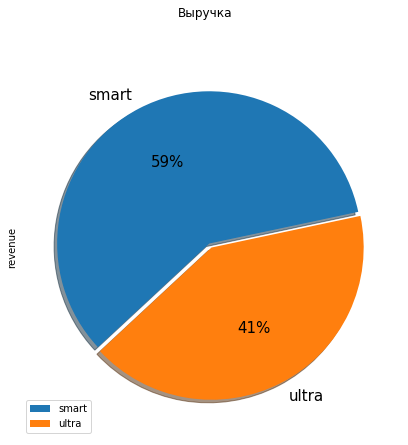

In [33]:
explode=(0.03, 0)
data.pivot_table(index='tariff', values='revenue', 
                 aggfunc = 'sum').plot( subplots = True, shadow = True, kind='pie', fontsize=15,
                figsize= (7,7), explode= explode,  startangle =12, title = 'Выручка', 
                                       autopct =lambda p: '{:.0f}%'.format(p))
plt.show()

Разница в выручке не такая большая как разница в аббонентах. Но все же выручка по тарифу Smart больше, на 12% чем по тарифу Ultra. 

Посмотрим какой тариф приносит больше прибыли за счет превышения лимитов по аббонетской плате.

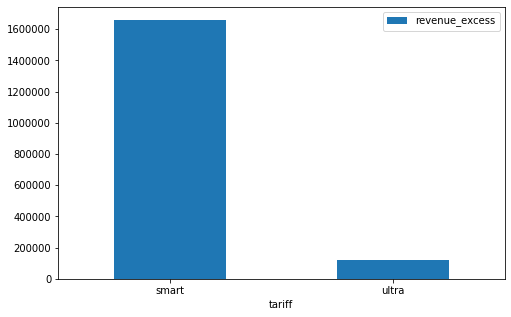

In [34]:
data.pivot_table(index='tariff', values='revenue_excess', aggfunc = 'sum').plot(y = 'revenue_excess', kind='bar', figsize=(8,5))
plt.xticks(rotation=0)
plt.show()

In [35]:
ultra_share= (data[(data['tariff']== "ultra")]['revenue_excess'].sum())/(data[(data['tariff']== "ultra")]['revenue'].sum())
smart_share= (data[(data['tariff']== "smart")]['revenue_excess'].sum())/(data[(data['tariff']== "smart")]['revenue'].sum())
print('Доля выручки по тарифу Ultra за превышение тарифа: {:.2%}'.format(ultra_share))
print('Доля выручки по тарифу Smart за превышение тарифа: {:.2%}'.format(smart_share))

Доля выручки по тарифу Ultra за превышение тарифа: 5.85%
Доля выручки по тарифу Smart за превышение тарифа: 57.52%


In [36]:
display(data.pivot_table(index='tariff', values=['Общее время звонков, мин','Интернет, мб','revenue','revenue_excess','Кол-во сообщений, шт'], aggfunc = 'sum'))

,revenue,revenue_excess,"Интернет, мб","Кол-во сообщений, шт","Общее время звонков, мин"
tariff,,,,,
smart,2885751,1659801,36174861,74413,931577
ultra,2040000,119250,19194598,48623,518724


53% выручки в тарифе Smart "Мегалайн" получает за счет того, что аббоненты превышают лимиты. А в тарифе Ultra лишь 6% выручки приходится на превышение лимитов.

Как видно из сводной таблицы аббоненты тарифа Smart отправляют больше сообщений, расходуют больше трафика интернета и больше разговаривают по телефону. За счет большего кол-ва аббонентов

Посмотрим на распределение аббонентов по городам

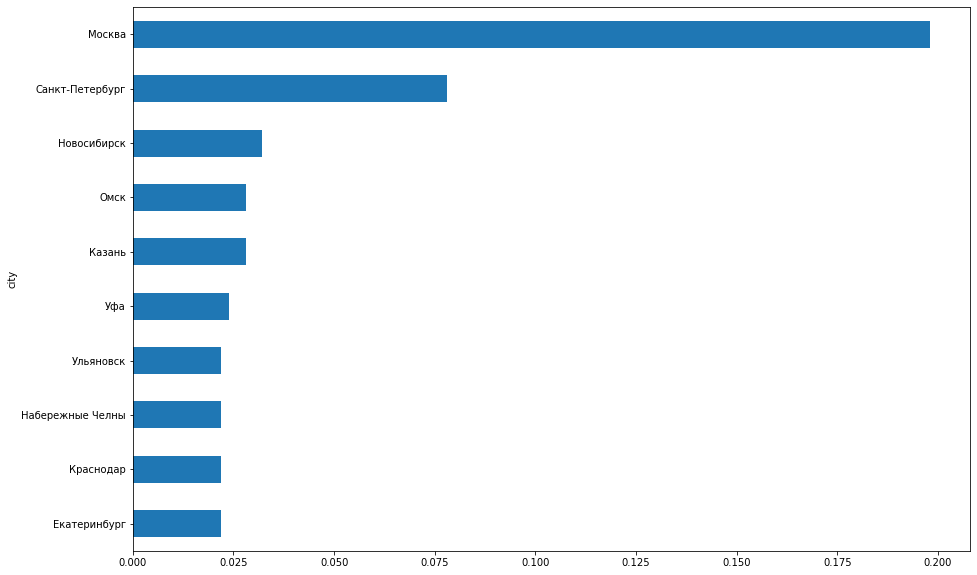

In [37]:
users_share = users.groupby('city').size()/len(users)
users_by_city_top = users_share[users_share>0.018]. sort_values()
ax= users_by_city_top.plot(kind= 'barh', figsize=(15,10), legend=False)

In [38]:
users_by_city=users.pivot_table(index= 'city', values = 'user_id', aggfunc= 'count')
users_by_city.columns=['count']
display(users_by_city.sort_values(by='count', ascending= False).head(10))

,count
city,
Москва,99
Санкт-Петербург,39
Новосибирск,16
Казань,14
Омск,14
Уфа,12
Набережные Челны,11
Краснодар,11
Екатеринбург,11


Больше всего аббонентов в Москве, их около 20% (99 аббонентов). Примерно 8% (39 аббонентов) приходится на Санкт-Петербург. В остальных городах меньше 3%.

Посмотрим на отдельные показатели по тарифам.

In [39]:
ultra_tariff = data[(data['tariff']== 'ultra')] # выборка, куда входят данные только по тарифу Ultra
smart_tariff = data[(data['tariff']== 'smart')] # выборка, куда входят данные только по тарифу Smart

Перед анализом определим границы для каждого тарифа, за которыми находятся выбросы. Для этого построим функцию с 1.5 квантилями. 

In [40]:
def data_range(column):
    q1 = ultra_tariff[column].quantile(0.25)
    q3 = ultra_tariff[column].quantile(0.75)
    irange = q3-q1
    int1 = np.where((q1-1.5*irange)>0, q1-1.5*irange, 0)
    int2 = np.where((q3+1.5*irange)>0, q3+1.5*irange, 0)
    print('Границы интервала тарифа Ultra  для "{}": {} - {}'.format(column, int1, int2))
    return(int1, int2)
for i in ['Интернет, мб', 'Общее время звонков, мин', 'Кол-во сообщений, шт', 'revenue']:
    data_range(i)

Границы интервала тарифа Ultra  для "Интернет, мб": 0.0 - 49480.0
Границы интервала тарифа Ultra  для "Общее время звонков, мин": 0.0 - 1454.0
Границы интервала тарифа Ultra  для "Кол-во сообщений, шт": 0.0 - 188.5
Границы интервала тарифа Ultra  для "revenue": 1950.0 - 1950.0


Постотрим revenue поближе на диаграмме размаха.

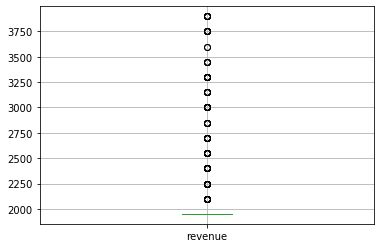

In [41]:
ultra_tariff.query('revenue<4000').boxplot('revenue')
plt.show()

За пределами 1950 находятся единичные выбросы. И когда выше анализировали общие данные, выяснили что лишь 6% аббонетов тарифа Ulta выходят за пределы аббонентской платы в 1950 руб. Это маленький процент, их можно считать выбросами. 

In [42]:
def data_range(column):
    q1 = smart_tariff[column].quantile(0.25)
    q3 = smart_tariff[column].quantile(0.75)
    irange = q3-q1
    int1 = np.where((q1-1.5*irange)>0, q1-1.5*irange, 0)
    int2 = np.where((q3+1.5*irange)>0, q3+1.5*irange, 0)
    print('Границы интервала тарифа Smart для "{}": {} - {}'.format(column, int1, int2))
    return(int1, int2)
for i in ['Интернет, мб', 'Общее время звонков, мин', 'Кол-во сообщений, шт', 'revenue']:
    data_range(i)

Границы интервала тарифа Smart для "Интернет, мб": 1543.0 - 31183.0
Границы интервала тарифа Smart для "Общее время звонков, мин": 0.0 - 939.5
Границы интервала тарифа Smart для "Кол-во сообщений, шт": 0.0 - 112.5
Границы интервала тарифа Smart для "revenue": 0.0 - 3550.0


Отфильтруем данные без выбросов. 

In [43]:
smart_tariff_select=smart_tariff[(smart_tariff['Интернет, мб']>=1543)&(smart_tariff['Интернет, мб']<=31183)&
        (smart_tariff['Общее время звонков, мин']<=940)&(smart_tariff['Кол-во сообщений, шт']<=113)&(smart_tariff['revenue']<=2903)]
ultra_tariff_select = ultra_tariff[(ultra_tariff['Интернет, мб']<=49480)&(ultra_tariff['Общее время звонков, мин']<=1454)&
                               (ultra_tariff['Кол-во сообщений, шт']<=189)&(ultra_tariff['revenue']==1950)]

Для опредения стастических выличин напишем  функцию

In [44]:
def measures(column):
    
    filtered_ultra_tariff=ultra_tariff_select[column]
    filtered_smart_tariff=smart_tariff_select[column]
    mean_smart=filtered_smart_tariff.mean()
    mean_ultra=filtered_ultra_tariff.mean()
    dispersion_smart=filtered_smart_tariff.var(ddof=1)
    dispersion_ultra=filtered_ultra_tariff.var(ddof=1) 
    std_smart = filtered_smart_tariff.std(ddof=1)  
    std_ultra = filtered_ultra_tariff.std(ddof=1)
    median_smart = filtered_smart_tariff.median()
    median_ultra = filtered_ultra_tariff.median()
    print ('\033[94m'+column+'\033[0m')
    print('\033[1m'+'Тариф Smart:'+'\033[0m')  
    print('Медиана: {:.0f}'.format(median_smart),', Среднее: {:.0f}'.format(mean_smart),
          ', Дисперсия: {:.0f}'.format(dispersion_smart), ', Станд. отклонение: {:.0f}'.format(std_smart))
    print ('\033[1m'+'Тариф Ultra:'+'\033[0m')
    print('Медиана: {:.0f}'.format(median_ultra),' Среднее: {:.0f}'.format(mean_ultra),
          ', Дисперсия: {:.0f}'.format(dispersion_ultra), ', Станд. отклонение: {:.0f}'.format(std_ultra))

### Гистограмма длительности звонков <a id="histcalls"></a>

In [45]:
measures('Общее время звонков, мин')

Общее время звонков, мин
Тариф Smart:
Медиана: 418 , Среднее: 412 , Дисперсия: 32028 , Станд. отклонение: 179
Тариф Ultra:
Медиана: 507  Среднее: 517 , Дисперсия: 94431 , Станд. отклонение: 307


У тарифа Smart медиана больше среднего (данные немного скошены влево), а у тарифа Ultra наоборот. Стандартное отклонение у тарифа Ultra больше, чем у Smart. Значит разброс данных у тарифа Ultra шире.

Построим гистограмму распределения длительности звонков.

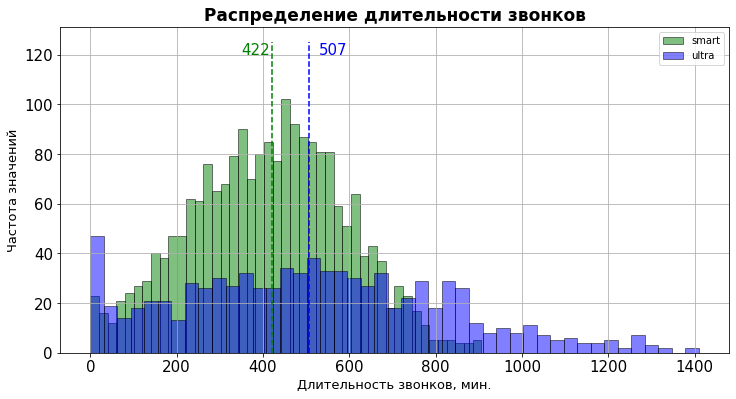

In [46]:
ax = smart_tariff_select.plot(kind='hist', y='Общее время звонков, мин', ec='black', bins=45, 
                              linewidth=1, alpha=0.5, label='smart', color='g')
ultra_tariff_select.plot(kind='hist', y='Общее время звонков, мин', ec='black', bins=45,linewidth=1, alpha=0.5, 
                         label='ultra', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
ax.vlines(422, 0, 125, color= 'g', linestyle ='--',)
ax.vlines(507, 0, 125, color= 'b', linestyle ='--',)
ax.text(530, 120, '507', fontsize=15, color='b')
ax.text(350, 120, '422', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Длительность звонков, мин.', fontsize=13)
ax.set_title('Распределение длительности звонков', fontsize=17, fontweight='bold')
plt.show()

Аббоненты тарифа Smart в основном разговаривают  300-550 минут в месяц. Медиана равна 422, это чуть меньше лимита в 500 мин по тарифу. При чем тех, кто укладывется в лимит больше, чем тех кто превышает(данные скошены влево)

На тарифе Ultra довольно много аббонетов, которые почти не разговаривают (или очень быстро разговаривают). Медиана равна 507 мин. И разброс данных действительно шире чем у аббонентов Smart. Это объясняется лимитом в 3000 минут в месяц. И основной диапазон длительности звонков шире - 200 - 700 минут

### Гистограмма используемого трафика интернета.  <a id="histinternet"></a>

In [47]:
measures('Интернет, мб')

Интернет, мб
Тариф Smart:
Медиана: 16191 , Среднее: 15797 , Дисперсия: 26444566 , Станд. отклонение: 5142
Тариф Ultra:
Медиана: 17365  Среднее: 16838 , Дисперсия: 63818128 , Станд. отклонение: 7989


У обоих тарифов медина больше среднего. Стандартное отклонение у тарифа Ultra немного больше, чем у Smart,  разброс данных у тарифа Ultra будет немного шире.

Построим гистограмму распреледения  использованного трафика интернета

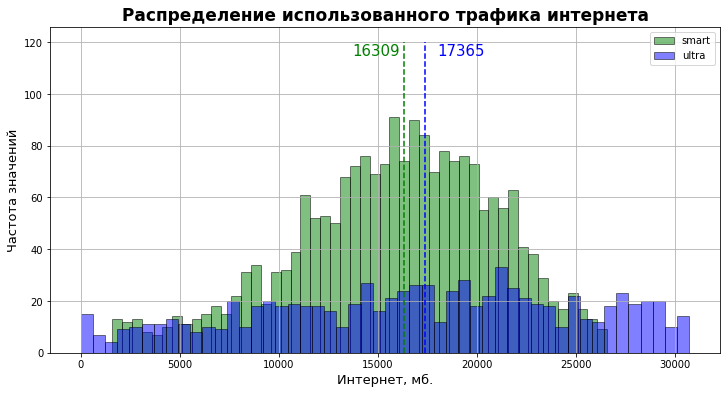

In [48]:
ax = smart_tariff_select.plot(kind='hist', y='Интернет, мб', ec='black' , bins=50, 
                              linewidth=1, alpha=0.5, label='smart', color='g')
ultra_tariff_select.plot(kind='hist', y='Интернет, мб', ec='black',bins=50, linewidth=1, alpha=0.5, 
                         label='ultra', ax=ax, figsize=(12,6),grid=True, legend=True, color='b')
ax.vlines(16309, 0, 120, color= 'g', linestyle ='--',)
ax.vlines(17365, 0, 120, color= 'b', linestyle ='--',)
ax.text(18000, 115, '17365', fontsize=15, color='b')
ax.text(13700, 115, '16309', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Интернет, мб.', fontsize=13)
ax.set_title('Распределение использованного трафика интернета', fontsize=17, fontweight='bold')
plt.show()

На тарифе Smart аббоненты в основном расходуют 13-20Гб интернета в месяц. Медиана 16,3Гб. Лимит по тарифу 15Гб. То есть аббоненты часто превышают лимит по тарифу и покупают дополнительный трафик

На тарифе Ultra данные распределены более равномерно. Большая часть аббонентов укладывается в лимит 30Гб. Медиана равна 17,3Гб. 

### Гистограмма количества отправленных сообщений <a id="histmess"></a>

In [49]:
measures('Кол-во сообщений, шт')

Кол-во сообщений, шт
Тариф Smart:
Медиана: 29 , Среднее: 33 , Дисперсия: 736 , Станд. отклонение: 27
Тариф Ultra:
Медиана: 38  Среднее: 48 , Дисперсия: 2005 , Станд. отклонение: 45


У обоих тарифов среднее больше медианы (скошенность данных вправо). Стандартное отклонение у тарифе Ultra значительно больше чем у тарифа Smart. Те разброс данных должен быть значительно больше у тарифа Ultra 

Построим гистограмму распредения количества отправленных сообщений

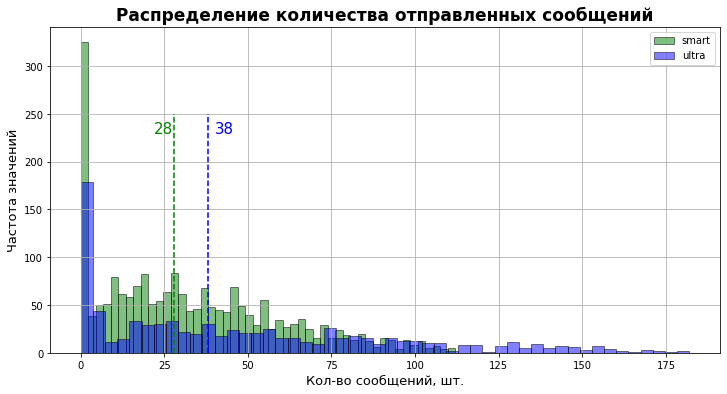

In [50]:
ax = smart_tariff_select.plot(kind='hist', y='Кол-во сообщений, шт', ec='black', bins=50, linewidth=1, alpha=0.5,
                              label='smart', color='g')
ultra_tariff_select.plot(kind='hist', y='Кол-во сообщений, шт', ec='black', bins=50, linewidth=1, alpha=0.5, 
                         label='ultra', ax=ax, figsize=(12,6),grid=True, legend=True,  color='b')
ax.vlines(28, 0, 250, color= 'g', linestyle ='--',)
ax.vlines(38, 0, 250, color= 'b', linestyle ='--',)
ax.text(40, 230, '38', fontsize=15, color='b')
ax.text(22, 230, '28', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Кол-во сообщений, шт.', fontsize=13)
ax.set_title('Распределение количества отправленных сообщений', fontsize=17, fontweight='bold')
plt.show()

У обоих тарифов большое кол-во аббонентов, которые не отправляют сообщения (либо отправляют в единичных кол-вах). Среди тех отправляет в основном: 
- на тарифе Smart от 10 до 50 сообщений, что в пределах лимита 50 сообщений.
- на тарифе Ultra  от 15 до 100 сообщений, при лимите в 1000 сообщений

Медиана на тарифе Smart 28 сообщений и довольно много случаев превышения лимита тарифа. Больше 100 сообщений почти никто не отправляет

Медиана на тарифе Ultra 38 сообщений, но до лимита не доходят, хотя разрос данных шире- от 0 до 180 сообщений


### Гистограмма выручки сверх тарифа <a id="histrevenue"></a>

In [51]:
measures('revenue_excess')

revenue_excess
Тариф Smart:
Медиана: 421 , Среднее: 632 , Дисперсия: 409768 , Станд. отклонение: 640
Тариф Ultra:
Медиана: 0  Среднее: 0 , Дисперсия: 0 , Станд. отклонение: 0


Среднее и медина сильно отличаются и станд. отклонение говорит о большом разбросе данных 

Построим гистограмму распределения дополнительной выручки по тарифу Smart. (По тарифу Ultra превышение по тарифам исключили из выборки, тк это всего 5% от общей выручки)

In [52]:
data.query('tariff == "ultra"')['revenue_excess'].describe()

count     985.000000
mean      121.065990
std       378.802377
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2850.000000
Name: revenue_excess, dtype: float64

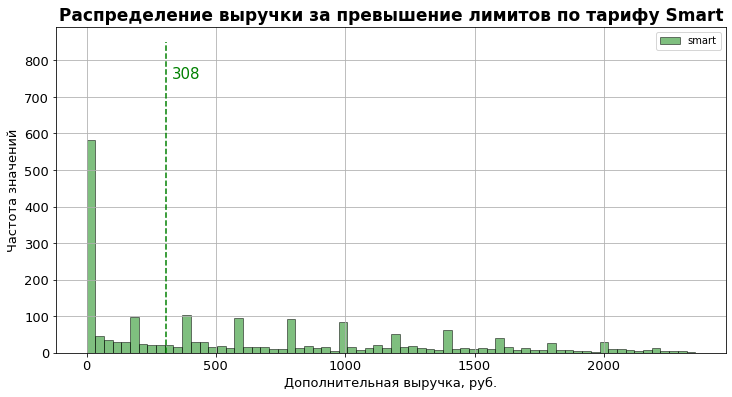

In [53]:
smart_tariff_select.plot(kind='hist', y='revenue_excess', ec='black', bins=70, fontsize = 13, figsize=(12,6), 
                         grid=True, legend=True, linewidth=1, alpha=0.5, label='smart', color='g')
plt.xlabel('Дополнительная выручка, руб.',fontsize = 13)
plt.ylabel('Частота значений',fontsize = 13)
plt.title('Распределение выручки за превышение лимитов по тарифу Smart',fontsize=17, fontweight='bold')
plt.text(330, 750, '308', fontsize=15, color='g')
plt.vlines(308, 0, 850, color= 'g', linestyle ='--',)
plt.show()

Раброс данных большой. Довольно много аббонентов покупает дополнительные услуги на сумму до 100 рублей. Но есть те кто тратит в добавок к аббонетской плате и 1000 и 2000 руб. 

Посмотрим какое было максимальное превышение

In [54]:
smart_tariff_select['revenue_excess'].max()

2353

Это даже больше аббонентской платы в 1950 руб на тарифе Ultra.

### Гистограмма общей выручки. <a id="histrevenuetotal"></a>

In [55]:
def analysis(df, usluga):
    
    # статистики
    pivot = df.pivot_table(index = 'tariff', values = usluga, aggfunc = ['median', 'mean', 'var', 'std'])
    print('Статистики по ', usluga)
    display(pivot)
    
    # гистграмма
    fig = px.histogram(df, x = usluga, color = 'tariff', marginal = 'box', title = 'Распределение '+usluga)
    fig.show("svg")
    
    # средний расход в месяцц
    fig = px.line(df.pivot_table(index = ['tariff', 'Месяц'], values = usluga, aggfunc = 'mean').reset_index(), x = 'Месяц', y = usluga, color = 'tariff', title = 'Средний расход в месяц '+usluga)
    fig.show("svg")
    

Статистики по  revenue


,median,mean,var,std
,revenue,revenue,revenue,revenue
tariff,,,,
smart,1038,1294.63930,673931.321363,820.933202
ultra,1950,2071.06599,143491.240560,378.802377


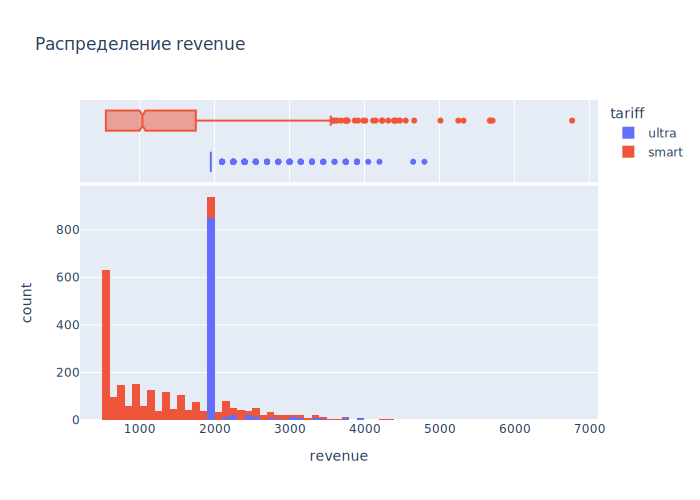

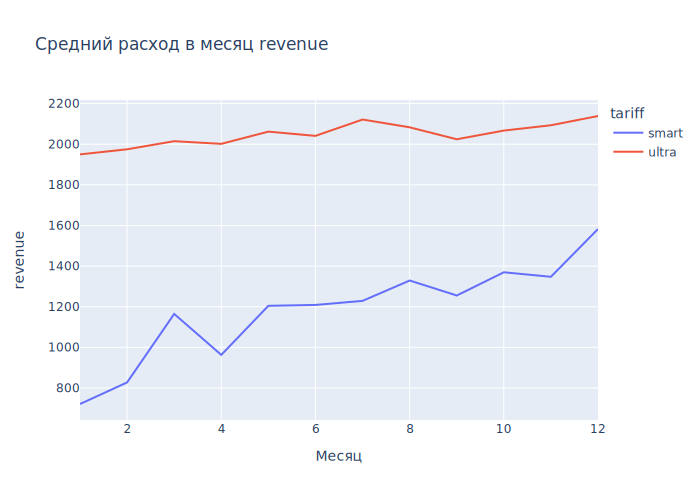

In [56]:
analysis(data, 'revenue')

Медиана на тарифе Ultra 1950 руб (что равно аббонентской плате), а на тарифе Smart  - 950 руб (это почти в 2 раза больше абонтской платы). А стандартное отклонение у Smart знаятельно больше чем у Ultra, те разброс данных будет больше у выручки по тарифу Smart.

Основная часть прибыли Smart приходится на траты аббонентов в 500-600 руб. Из гистораммы видно что дальнейшее распределение прибыли чаще кратно 200 руб, что может быть за счет покупки дополнительного пакета интернета (200 руб за 1Гб)

На тарифе Ultra случаи, когда выручка превышала аббонентскую плату, единичны. Их даже меньше случаев, когда выручка по Smart превышала 1950 руб.

У обоих тарифов среднемесячная выручка выросла к концу года. И на протяжении всего года среднемесячная выручка на тарифе  Ultra была выше чем на тарифе Smart, однако прирост выручки в конце года, по сравнению с началом, выше у тарифа Smart (почти в 2 раза прирост)

**Выводы**

Из анализа данных видно, что у тарифа Smart больше аббонентов, выручка также больше и кол-во аббонетов, превышающих лимиты тарифа, значительно превышает аналогичные параметры у тарифа Ultra. В Москве и Санкт-Петербурге больше всего аббонентов. Аббоненты тарифа Ultra в среднем дольше разговаривают по телефону, отправляют больше сообщений и расходуют больше интернет трафика, но при этом случаи когда аббоненты превышают аббонентскую плату единичны.
У тарифа Smart прирост среднемесячной выручки к концу году, по сравнению с началом года, оказался больше чем у Ulta

## Проверка гипотез <a id="suppose"></a>

### Первая гипотеза: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" <a id="version1"></a>

Нулевая гипотеза(Н0). Между данными нет связи. Предположим что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается

Альтернативная теория(Н1).  Выручка пользователей тарифов «Ультра» отличается от средней выручка пользователей тарифа «Смарт»

Проверим гипотезу о равенстве средних

In [57]:
variance_estimate_ultra = np.var(ultra_tariff['revenue'], ddof=1)
variance_estimate_smart = np.var(smart_tariff['revenue'], ddof=1)
print('Дисперсия выручки по тарифу Ultra', variance_estimate_ultra)
print('Дисперсия выручки по тарифу Smart', variance_estimate_smart)

Дисперсия выручки по тарифу Ultra 143491.24055961063
Дисперсия выручки по тарифу Smart 673931.3213632498


Дисперсии отличаются более чем на 5%, значит они разные и параметр equal_var считаем Flase

In [58]:
smart_mean_revenue = data[(data['tariff']== 'smart')]['revenue']
ultra_mean_revenue = data[(data['tariff']== 'ultra')]['revenue']

alpha = 0.05 
results = st.ttest_ind(
    smart_mean_revenue, 
    ultra_mean_revenue, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


p-значение оказалось очень маленьким и получить различия случайно маловероятно. На этом основании отвергаем нулевую гипотезу H0. В среднем по выручке тарифов имеются статистически значимые различия.


Проверим у кого больше.

In [59]:
print('Средняя выручка по тарифу Smart: {:.2f}'.format(smart_mean_revenue.mean()))
print('Средняя выручка по тарифу Ultra: {:.2f}'.format(ultra_mean_revenue.mean()))

Средняя выручка по тарифу Smart: 1294.64
Средняя выручка по тарифу Ultra: 2071.07


Выручка у тарифа Ultra больше чем у тарифа Smart.

### Вторая гипотеза: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" <a id="version2"></a>


Нулевая гипотеза(Н0). Между данными нет связи. Предположим что средняя выручка пользователей из Москвы и из других регионов не различается

Альтернативная теория(Н1).  Выручка пользователей тарифов из Москвы отличается от выручки пользователей из других регионов

Сделам выборку по городу и найдем границы показателей ревенью, за которыми находятся выбросы

In [60]:
data_moscow= data[data['city'] == 'Москва']  #Выборка по Москве
data_region =data[data['city'] != 'Москва']  #Выборка по регионам
def data_range(column):
    q1 = data_moscow[column].quantile(0.25)
    q3 = data_moscow[column].quantile(0.75)
    irange = q3-q1
    int1 = np.where((q1-1.5*irange)>0, q1-1.5*irange, 0)
    int2 = np.where((q3+1.5*irange)>0, q3+1.5*irange, 0)
    print('Границы интервала для Москвы для "{}": {} - {}'.format(column, int1, int2))
    return(int1, int2)
for i in ['revenue']:
    data_range(i)

Границы интервала для Москвы для "revenue": 0.0 - 3678.0


In [61]:
def data_range(column):
    q1 = data_region[column].quantile(0.25)
    q3 = data_region[column].quantile(0.75)
    irange = q3-q1
    int1 = np.where((q1-1.5*irange)>0, q1-1.5*irange, 0)
    int2 = np.where((q3+1.5*irange)>0, q3+1.5*irange, 0)
    print('Границы интервала для регионов для "{}": {} - {}'.format(column, int1, int2))
    return(int1, int2)
for i in ['revenue']:
    data_range(i)

Границы интервала для регионов для "revenue": 0.0 - 3750.0


Проверим гипотезу о равенстве средних.

In [62]:
moscow_mean_revenue = data_moscow[data_moscow['revenue'] <= 4001]['revenue']
region_mean_revenue = data_region[data_region['revenue'] <= 4004]['revenue']
variance_estimate_moscow = np.var(moscow_mean_revenue, ddof=1)
variance_estimate_region = np.var(region_mean_revenue, ddof=1)
print('Дисперсия выручки по Москве', variance_estimate_moscow)
print('Дисперсия выручки по регионам', variance_estimate_region)

Дисперсия выручки по Москве 524221.92607896763
Дисперсия выручки по регионам 575656.7550962624


Дисперсии выручек отличаются менее чем на 5%, значит можем считать их равными и параметр equal_var будет True

In [63]:

alpha = 0.05 
results = st.ttest_ind(
    moscow_mean_revenue, 
    region_mean_revenue,  equal_var= True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3285262028401055
Не получилось отвергнуть нулевую гипотезу


Выручка по Москве и по регионам имеет определенные различия и с вероятностью 15% получить их можно случайно. Это слишком высокая вероятность случайности, которая выше порога 5%. Поэтому у нас нет достаточных оснований полагать, что различия статистически значимы. Значит нулевую теорию (Н0) о том, что выручки не отличаются не отвергаем.

Посмотрим чему они равны.

In [64]:
print('Средняя выручка по Москве: {:.2f}'.format(moscow_mean_revenue.mean()))
print('Средняя выручка по регионам: {:.2f}'.format(region_mean_revenue.mean()))

Средняя выручка по Москве: 1536.27
Средняя выручка по регионам: 1503.14


Разница 50 рублей

**Вывод**

Исходя из двустронних гипотез и результатов статистического теста можно сказать, что выручка по тарифам Smart и Ultra различна, а по Москве и регионам схожа.

## Общий вывод <a id="inference"></a>

В предоставленной выборке данных у тарифа Smart более чем в 2 раза больше аббонетов и он приносит компании 56% выручки. На тариф Ulta приходится 44% выручки. Тариф Smart побеждает за счет численности аббонентов

Средняя выручка у тарифов различается. У тарифа Ulta она больше. У обоих тарифов среднемесячная выручка выросла к концу года. Но среднемесячная выручка у тарифа Smart в течении года росла быстрее чем у тарифа Ulta и к концу года выросла почти в 2 раза. У тарифа Ultra прирост к концу года был меньше 10%.

Аббонетам тарифа Smart часто не хватает выделенных лимитов и они покупают дополнительный пакет услуг. 53% прибыли на этом тарифе приходитя на платежы сверх аббонентской платы. 
Аббоненты тарифа Ultra в среднем используют больше трафика интернета и дольше разговаривают, но они не выходят за рамки тарифа, лишь 6% прибыли это платежы сверх аббонентской платы. В обоих тарифах есть большое число клиентов, которые не отправляют (или почти не отправляют) сообщения.

В среднем аббоненты тарифа Smart покупают дополнительные услуги на 500 р. Но есть и те, кто покупает дополнительные  услуги на сумму, превышающую даже аббонентскую плату тарифа Ultra в 1950 руб.  Максимальная переплата составила 2348 руб. 

В Москве у компании больше всего аббонентов (ок 20%), но это не влияет на выручку. Средняя выручка аббонетов Москвы и регионов схожа

Тариф Smart более попурен у аббонентов и приносит больше прибыли. Но тк средняя выручка у тарифа Ultra больше, то для увелечения прибыли компания могла бы увеличить кол-во аббонентов по тарифу Ultra через рекламную компанию, предложив дополнительные услуги за подключение. Можно было бы расширить тарифную сетку, добавив еще один или два тарифа, как промежуточные между Smart и Ultra